In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tfd = tfp.distributions

from IPython import display
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [3]:
for layer in inception.layers:
    layer.trainable = False

model = tf.keras.models.Model(inputs=inception.input,
                              outputs=[inception.get_layer('mixed2').output,
                                       inception.get_layer('mixed4').output])

assert len(model.trainable_variables) == 0, 'There should be no trainable variables.'

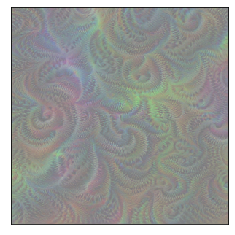

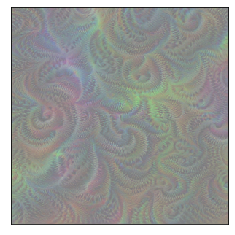

In [7]:
def gaussian_kernel(size: int,
                    mean: float,
                    std: float,
                   ):
    """Makes 2D gaussian Kernel for convolution."""

    d = tfd.Normal(mean, std)

    vals = d.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))

    gauss_kernel = tf.einsum('i,j->ij',
                                  vals,
                                  vals)

    return gauss_kernel / tf.reduce_sum(gauss_kernel)

x0 = tf.random.normal(shape=(1, 299, 299, 3), mean=0.0, stddev=1.0, name='input')
x = tf.Variable(tf.clip_by_value(x0, -1, 1))

def plot_image(im):
    IM = (x[0].numpy() + 1) * 127.5
    IM = np.clip(IM, 0, 255)
    IM = IM.astype(int)

    plt.imshow(IM)
    plt.xticks([])
    plt.yticks([])

    display.clear_output(wait=True)
    display.display(plt.gcf())

for _iter in range(100):
    with tf.GradientTape() as tape:
        tape.watch([x])
        losses = []
        layer_activations = model(x, training=False)
        for act in layer_activations:
            loss = tf.math.reduce_mean(act)
            losses.append(loss)
        loss = tf.reduce_sum(losses) + 1e-7 * tf.reduce_sum(tf.image.total_variation(x))
        grads = tape.gradient(loss, x)
        grads /= tf.math.reduce_std(grads) + 1e-8
        for ind in range(3):
            K = gaussian_kernel(size=1, mean=0, std= 10 / (_iter + 1 )) 
            K = K[:, :, tf.newaxis, tf.newaxis]
            channel = tf.nn.conv2d(tf.expand_dims(x[..., ind], axis=-1),
                                     K, strides=[1, 1, 1, 1], padding='SAME')
            x[..., ind].assign(channel[..., 0])
        x = tf.image.random_saturation(x, 0.95, 1.05)
        x = tf.image.central_crop(x, central_fraction= 0.95 + 0.05 * _iter / 100)
        x = tf.image.resize(x, size=(299, 299))
        x = tf.Variable(x)
        x = x + grads * 0.01
        x = tf.Variable(tf.clip_by_value(x, -1, 1))
        if _iter % 9 == 0:
            plot_image(x)

In [8]:
def deepdream_loss(model_outputs):
    losses = []
    layer_activations = model_outputs
    for layer_activation in layer_activations:
        loss = tf.math.reduce_mean(layer_activation)
        losses.append(loss)
    return tf.reduce_sum(losses)

def single_node_loss(model_output):
    return tf.reduce_sum(model_output)

def single_channel_loss(model_output):
    return tf.reduce_mean(model_output)

# Src : stackoverflow.com
def gaussian_kernel(size: int,
                    mean: float,
                    std: float,
                   ):
    """Makes 2D gaussian Kernel for convolution."""

    d = tfd.Normal(mean, std)

    vals = d.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))

    gauss_kernel = tf.einsum('i,j->ij',
                                  vals,
                                  vals)

    return gauss_kernel / tf.reduce_sum(gauss_kernel)

def apply_gaussian_blur(image, mean, sigma, kernel_size):
    channels = []
    for ch in range(image.shape[-1]):
        K = gaussian_kernel(size=kernel_size // 2, mean=mean, std=sigma)
        K = K[:, :, tf.newaxis, tf.newaxis]
        channel = tf.nn.conv2d(tf.expand_dims(image[..., ch], axis=-1),
                                     K, strides=[1, 1, 1, 1], padding='SAME')
        channels.append(channel)
    return tf.concat(channels, axis=3)

@tf.function(experimental_relax_shapes=True)
def make_step(x, model, loss_fn,
              step_size=tf.constant(1e-2, dtype=tf.float32),
              sigma=tf.constant(10, dtype=tf.float32)):
    with tf.GradientTape() as tape:
        tape.watch([x])
        y = model(x, training=False)
        loss = loss_fn(y)
        grads = tape.gradient(loss, x)
        # normalizing the gradients
        grads /= tf.math.reduce_std(grads) + 1e-8
        x = apply_gaussian_blur(x, 0, sigma, 3)
        x = x + grads * step_size
        x = tf.clip_by_value(x, -1, 1)
    return x

In [9]:
N_STEPS = 200

x0 = tf.random.normal(shape=(1, 299, 299, 3), mean=0.0, stddev=1, name='input')
x0 = tf.Variable(tf.clip_by_value(x0, -1, 1))

def jitter(d, seed=None):
    def inner(t_image):
        t_image = tf.convert_to_tensor(t_image, dtype=tf.float32)
        t_shp = tf.shape(t_image)
        crop_shape = tf.concat([t_shp[:-3], t_shp[-3:-1] - d, t_shp[-1:]], 0)
        crop = tf.image.random_crop(t_image, crop_shape, seed=seed)
        shp = t_image.get_shape().as_list()
        mid_shp_changed = [
            shp[-3] - d if shp[-3] is not None else None,
            shp[-2] - d if shp[-3] is not None else None,
        ]
        crop.set_shape(shp[:-3] + mid_shp_changed + shp[-1:])
        return crop

    return inner

def pad(w, mode="REFLECT", constant_value=0.5):
    def inner(t_image):
        if constant_value == "uniform":
            constant_value_ = tf.random_uniform([], 0, 1)
        else:
            constant_value_ = constant_value
        return tf.pad(
            t_image,
            [(0, 0), (w, w), (w, w), (0, 0)],
            mode=mode,
            constant_values=constant_value_,
        )

    return inner

def run_visualizer(x0, model, loss_fn, n_steps=N_STEPS, octave_scale=1.15, no_jitter=False, no_pad=False):
    x = x0
    sigma0 = 25.
    
    base_shape = x.shape[1:-1]
    float_base_shape = tf.cast(base_shape, tf.float32)
    
    for step in range(n_steps):
        
        octave_scale_factor = step // n_steps - 1
        new_shape = tf.cast(float_base_shape * octave_scale ** octave_scale_factor, tf.int32)
        if base_shape != new_shape:
            x = tf.image.resize(x, size=new_shape)
        
        if np.random.uniform() > .75 and not no_jitter:
            x = jitter(2)(x)
            
        if np.random.uniform() > .75 and not no_pad and step < 50:
            x = pad(3)(x)
        
        crt_sigma = tf.constant(sigma0 / tf.cast(step + 1, dtype=tf.float32))
        x = make_step(x, model, loss_fn, sigma = crt_sigma)    
        if step % 9 == 0:
            IM = (x[0].numpy() + 1) * 127.5
            IM = np.clip(IM, 0, 255)
            IM = IM.astype(int)

            plt.imshow(IM)
            plt.xticks([])
            plt.yticks([])
    
            display.clear_output(wait=True)
            display.display(plt.gcf())

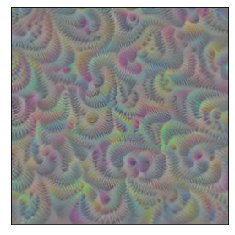

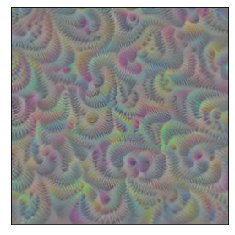

In [10]:
x0 = tf.random.normal(shape=(1, 299, 299, 3), mean=0.0, stddev=1, name='input')
x0 = tf.Variable(tf.clip_by_value(x0, -1, 1))

run_visualizer(x0, model, deepdream_loss)

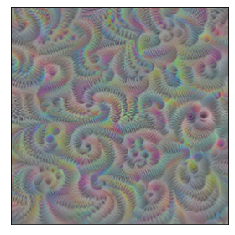

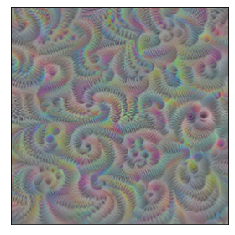

In [11]:
x0 = tf.random.uniform(shape=(1, 299, 299, 3), minval=-1., maxval=1., name='input')
x0 = tf.Variable(tf.clip_by_value(x0, -1, 1))

run_visualizer(x0, model, deepdream_loss)

In [12]:
for layer in inception.layers:
    layer.trainable = False

model = tf.keras.models.Model(inputs=inception.input,
                              outputs=inception.get_layer('mixed4').output[:, :, :, 42])

assert len(model.trainable_variables) == 0, 'There should be no trainable variables.'

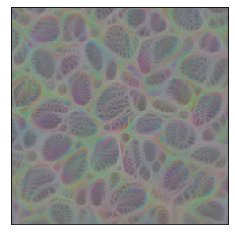

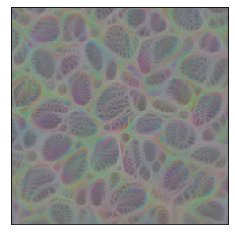

In [13]:
x0 = tf.random.normal(shape=(1, 299, 299, 3), mean=0.0, stddev=1, name='input')
x0 = tf.Variable(tf.clip_by_value(x0, -1, 1))

run_visualizer(x0, model, single_channel_loss)

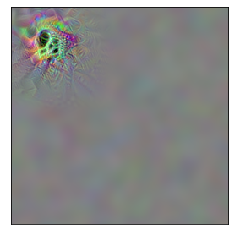

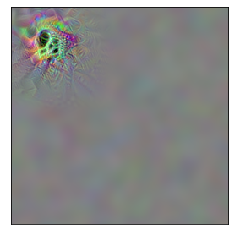

In [14]:
for layer in inception.layers:
    layer.trainable = False

model = tf.keras.models.Model(inputs=inception.input,
                              outputs=inception.get_layer('mixed4').output[:, 2, 2, 42])

assert len(model.trainable_variables) == 0, 'There should be no trainable variables.'

x0 = tf.random.normal(shape=(1, 299, 299, 3), mean=0.0, stddev=1, name='input')
x0 = tf.Variable(tf.clip_by_value(x0, -1, 1))

run_visualizer(x0, model, single_node_loss)

In [15]:
inception = tf.keras.applications.InceptionV3(weights='imagenet')

for layer in inception.layers:
    layer.trainable = False

model = tf.keras.models.Model(inputs=inception.input,
                              outputs=inception.get_layer('predictions').output[:, 0])

assert len(model.trainable_variables) == 0, 'There should be no trainable variables.'

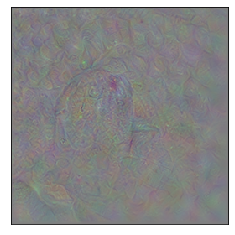

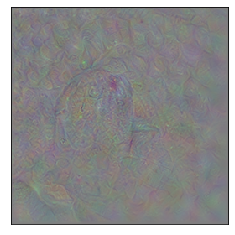

In [16]:
x0 = tf.random.normal(shape=(1, 299, 299, 3), mean=0.0, stddev=1, name='input')
x0 = tf.Variable(tf.clip_by_value(x0, -1, 1))

run_visualizer(x0, model, single_node_loss, no_jitter=True, no_pad=True)

In [17]:
def logodds_model():
    for layer in inception.layers:
        layer.trainable = False
        
    sub_model = tf.keras.models.Model(inputs=inception.input, outputs=inception.get_layer('avg_pool').output)
        
    weights, biases = inception.get_layer('predictions').get_weights()
    
    logodds = tf.add(tf.matmul(sub_model.output, weights), biases)
    
    model = tf.keras.models.Model(inputs=sub_model.input, outputs=logodds[:, 0])
    
    return model

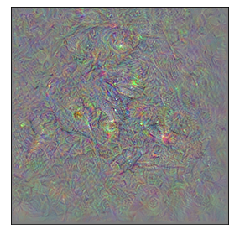

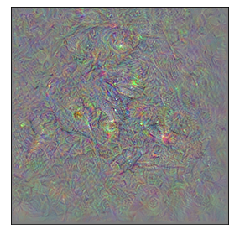

In [18]:
model_logodds = logodds_model()

run_visualizer(x0, model_logodds, single_node_loss, no_jitter=True, no_pad=True)